In [2]:
#importing some of the useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


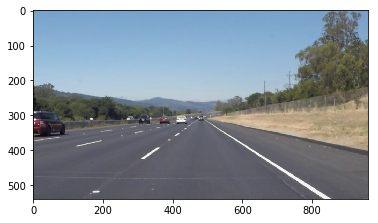

In [41]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
mpimg.imsave("test_images_output/TestImage.jpeg",image)

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

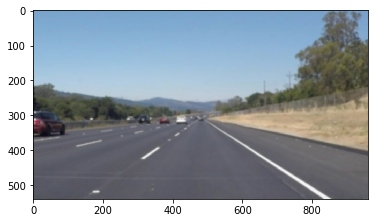

In [34]:
# Define a function to Apply a Gaussian Noise kernel
def gaussian_blur(image, kernel_size):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

# Define a kernel size and 
kernel_size = 9

# apply Gaussian smoothing
gray_blur = gaussian_blur(image, kernel_size)

# plot the image
plt.imshow(gray_blur)

mpimg.imsave("test_images_output/gray_blur.jpeg",gray_blur)

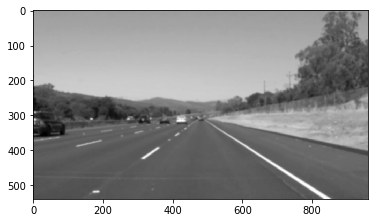

In [39]:
# Define a Function to convert the image to grayscale
# This will return an image with only one color channel
def gray_scale_transform(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


# Apply the gray scale transformation
grayscaled = gray_scale_transform(gray_blur)

# plot the image
plt.imshow(grayscaled,cmap='gray')

mpimg.imsave("test_images_output/gray_scaled1.jpeg",grayscaled)

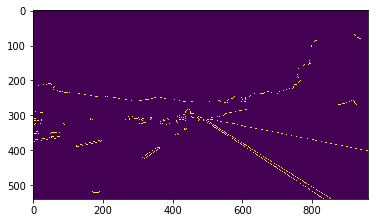

In [31]:
# Define a function to Apply the Canny transformation
def detect_edges(image, low_threshold, high_threshold):
    return cv2.Canny(image, low_threshold, high_threshold)

# Define  parameters for Canny
low_threshold = 50
high_threshold = 150

#Apply the cany transformation
edges = detect_edges(grayscaled, low_threshold,high_threshold)

# plot the image
plt.imshow(edges)

mpimg.imsave("test_images_output/detect_edges.jpeg",edges)

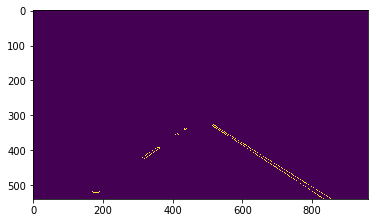

In [40]:
# Function to get the region of interest by applying an image mask
# Only keeps the region of the image defined by the polygon formed from `vertices`. 
# The rest of the image is set to black.
def region_of_interest(image, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(image)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

# Now the masking
# calculate vertices for region of interest
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 325), (550, 325), (imshape[1],imshape[0])]], dtype=np.int32)

# return the image only where mask pixels are nonzero
masked_img = region_of_interest(edges, vertices)

# Save the image
mpimg.imsave("test_images_output/RegionOfInterest.jpeg",masked_img)

# plot the image
plt.imshow(masked_img)

In [26]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=6):
    """
    This function draws `lines` with `color` and `thickness`.    
    """
    imshape = image.shape
    
    # these variables represent the y-axis coordinates to which 
    # the line will be extrapolated to
    ymin_global = image.shape[0]
    ymax_global = image.shape[0]
    
    # left lane line variables
    all_left_grad = []
    all_left_y = []
    all_left_x = []
    
    # right lane line variables
    all_right_grad = []
    all_right_y = []
    all_right_x = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            gradient, intercept = np.polyfit((x1,x2), (y1,y2), 1)
            ymin_global = min(min(y1, y2), ymin_global)
            
            if (gradient > 0):
                all_left_grad += [gradient]
                all_left_y += [y1, y2]
                all_left_x += [x1, x2]
            else:
                all_right_grad += [gradient]
                all_right_y += [y1, y2]
                all_right_x += [x1, x2]
    
    left_mean_grad = np.mean(all_left_grad)
    left_y_mean = np.mean(all_left_y)
    left_x_mean = np.mean(all_left_x)
    left_intercept = left_y_mean - (left_mean_grad * left_x_mean)
    
    right_mean_grad = np.mean(all_right_grad)
    right_y_mean = np.mean(all_right_y)
    right_x_mean = np.mean(all_right_x)
    right_intercept = right_y_mean - (right_mean_grad * right_x_mean)
    
    # Make sure we have some points in each lane line category
    if ((len(all_left_grad) > 0) and (len(all_right_grad) > 0)):
        upper_left_x = int((ymin_global - left_intercept) / left_mean_grad)
        lower_left_x = int((ymax_global - left_intercept) / left_mean_grad)
        upper_right_x = int((ymin_global - right_intercept) / right_mean_grad)
        lower_right_x = int((ymax_global - right_intercept) / right_mean_grad)

        cv2.line(image, (upper_left_x, ymin_global), 
                      (lower_left_x, ymax_global), color, thickness)
        cv2.line(image, (upper_right_x, ymin_global), 
                      (lower_right_x, ymax_global), color, thickness)

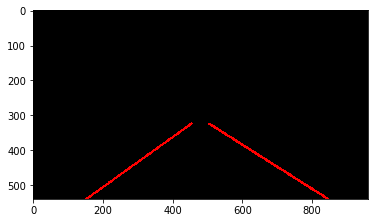

In [27]:
# Identify the location of lane lines on the road
def hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
   
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Define the parameters
rho = 4
theta = np.pi/180
threshold = 30
min_line_len = 100
max_line_gap = 180

houghed_img = hough_lines(masked_img, rho, theta, threshold, min_line_len, max_line_gap)

plt.imshow(houghed_img)
mpimg.imsave("test_images_output/houghed_image.jpeg",houghed_img)

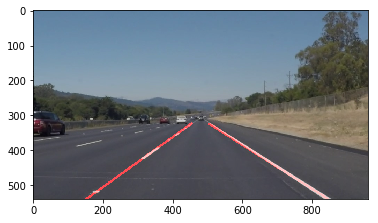

In [33]:
def weighted_image(image, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, image, β, λ)
  
# outline the input image
colored_image = weighted_image(houghed_img, image)

plt.imshow(colored_image)
mpimg.imsave("test_images_output/weighted_image.jpeg",colored_image)

In [10]:

import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [65]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # grayscale the image
    grayscaled = gray_scale_transform(image)

    # apply gaussian blur
    kernelSize = 5
    gaussianBlur = gaussian_blur(grayscaled, kernelSize)

    # canny
    # Define  parameters for Canny
    low_threshold = 100
    high_threshold = 200

    #Apply the cany transformation
    edges = detect_edges(gray, low_threshold,high_threshold)

    # get the parameters for the vertices
    xsize = edges.shape[1]
    ysize = edges.shape[0]
    dx1 = int(0.0725 * xsize)
    dx2 = int(0.425 * xsize)
    dy = int(0.6 * ysize)


    # calculate vertices for region of interest
    vertices = np.array([[(dx1, ysize), (dx2, dy), (xsize - dx2, dy), (xsize - dx1, ysize)]], dtype=np.int32)


    # return the image only where mask pixels are nonzero
    masked_img = region_of_interest(edges, vertices)

    # hough lines
    rho = 1
    theta = np.pi/180
    threshold = 30
    min_line_len = 20 
    max_line_gap = 20

    line_image = hough_lines(masked_img, rho, theta, threshold, min_line_len, max_line_gap)
    result = weighted_image(line_image, image, α=0.8, β=1., λ=0.)
    return result


for source_img in os.listdir("test_images/"):
    first_frame = 1
    image = mpimg.imread("test_images/"+source_img)
    processed = process_image(image)
    mpimg.imsave("test_images/OutputFiles_"+source_img,processed)



error: /Users/jenkins/miniconda/1/x64/conda-bld/conda_1486587097465/work/opencv-3.1.0/modules/core/src/arithm.cpp:639: error: (-209) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function arithm_op
